# 0. Libaries Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib
import re

# 1. Data Visualization & Preparation
- **Dataset #1.** Emotion Dataset for Emotion Recognition Tasks  
(16,000 training, 2,000 validation, and 2,000 test tweets with corresponding labels)  
https://www.kaggle.com/datasets/parulpandey/emotion-dataset  
- **Dataset #2.** Sentiment Analysis Word Lists Dataset  
(Lists of positive and negative words)  
https://www.kaggle.com/datasets/prajwalkanade/sentiment-analysis-word-lists-dataset 

In [2]:
# Load the first datasets (lists of setencnces)

# Load the training data
data = pd.read_csv('dataset/training.csv')

# Load the validation data
valid_data = pd.read_csv('dataset/validation.csv')

# Load the test data
test_data = pd.read_csv('dataset/test.csv')

# 0 = sad
# 1 = joy
# 2 = love
# 3 = anger
# 4 = fear
# 5 = surprise

# Load and preprocess the second datasets (lists of words for sentiment analysis)
negativewords = pd.read_csv('words/negative-words.csv')
negativewords = negativewords.rename(columns={'2-faced': 'neg'})
negativewords['val'] = [-1 for _ in range(len(negativewords))]
negative_words = set(negativewords['neg'].str.lower())
    
positivewords = pd.read_csv('words/positive-words.csv')
positivewords = positivewords.rename(columns={'a+': 'pos'})
positivewords['val'] = [1 for _ in range(len(positivewords))]
positive_words = set(positivewords['pos'].str.lower())

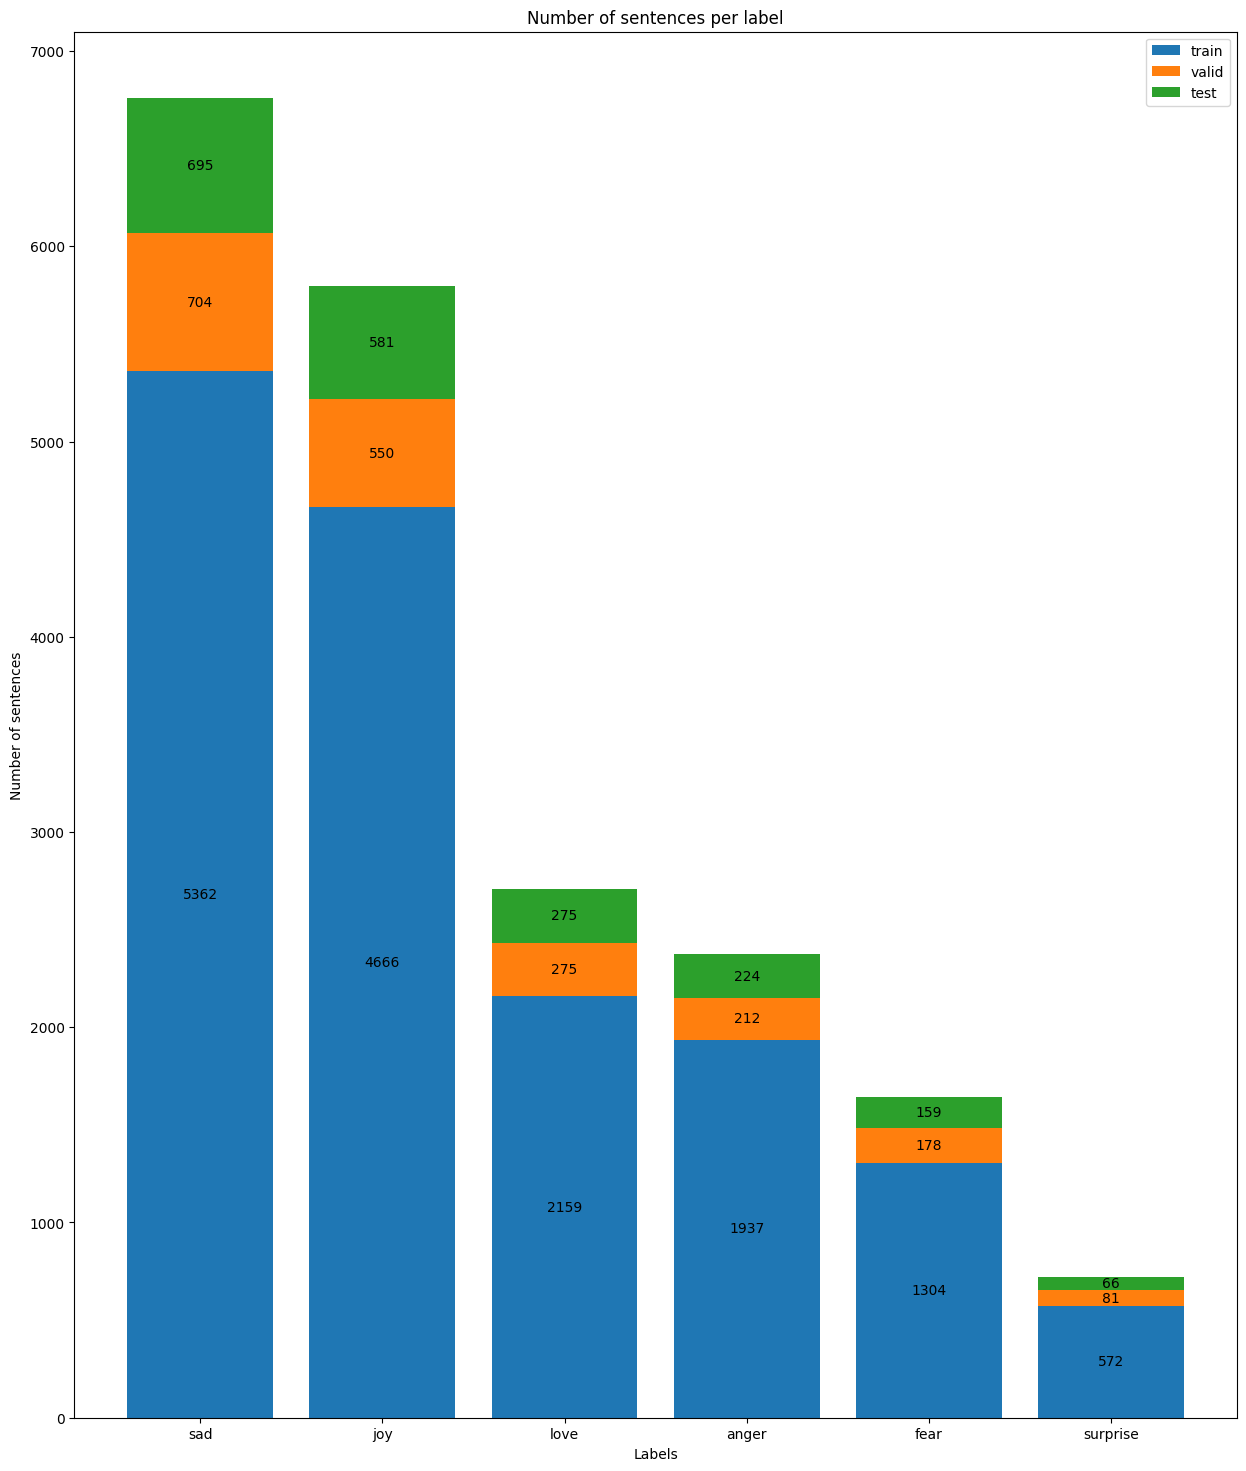

In [3]:
fig, ax = plt.subplots(figsize=(15, 18))
bottom = np.zeros(6)
emotion = ['sad', 'joy', 'love', 'anger', 'fear', 'surprise']

dataset_counts = {
    'train': data['label'].value_counts(),
    'valid': valid_data['label'].value_counts(),
    'test': test_data['label'].value_counts()
}

for dataset, counts in dataset_counts.items():
    p = ax.bar(emotion, counts, label=dataset, bottom=bottom)
    bottom += counts
    ax.bar_label(p, label_type='center')

plt.legend(loc='upper right', labels=['train', 'valid', 'test'])
plt.title('Number of sentences per label')
plt.xlabel('Labels')
plt.ylabel('Number of sentences')
plt.show()

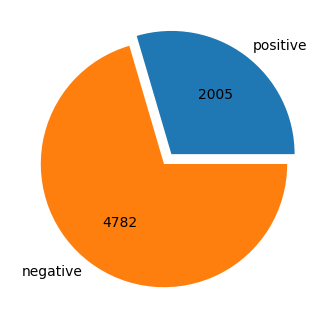

In [4]:
pltfig, ax = plt.subplots(figsize=(5,4))
labels = ['positive', 'negative']
sizes = [len(positivewords), len(negativewords)]

def absolute_value(val):
    total_size = sum(sizes)
    absolute_val = int(round(val/100.*total_size))
    return f"{absolute_val:d}"

ax.pie(sizes, labels=labels, explode = (0.1, 0), autopct=absolute_value)
plt.show()

# 2. Data Transformation
- **Feature Selection:** sentiment score, text length, and word count
- **Feature Engineering:** 
    - Convert text data into numerical feature vectors
    - Normalize the text length and word count data through Min/Max scaling

In [5]:
# helper function to compute the sentiment of a sentence
def parsing_words(s):
    words = re.findall(r'\b\w+\b', s.lower())
    val = []
    for word in words:
        if word in negative_words:
            val.append(-1)
        if word in positive_words:
            val.append(1)
    if len(val) != 0:
        return sum(val) / len(val)
    return 0

In [6]:
# Global variables for vectorizer and scaler to ensure they are fitted only once
vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=5000, min_df=5)
vectorizer.fit(data['text'])

scaler = MaxAbsScaler()
data['text_length'] = data['text'].apply(len)
data['word_count'] = data['text'].apply(lambda x: len(x.split()))
scaler.fit(data[['text_length', 'word_count']])

# Initialize vectorizer for word counts, with some limitations to avoid memory issues
# Function to create additional features without converting to dense array
def create_features(df):
    # Text length and word count
    df['text_length'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))

    # Sentiment score
    df['sentiment_score'] = df['text'].apply(parsing_words)
    
    # Transform text with vectorizer
    X_vect = vectorizer.transform(df['text'])
    
    # Scale text_length and word_count
    scaled_features = scaler.transform(df[['text_length', 'word_count']])
    
    all_features = np.hstack((scaled_features, df[['sentiment_score']].to_numpy()))
    all_features_sparse = csr_matrix(all_features)

    # Combine the additional features with the vectorized text (all in sparse format)
    X_combined = hstack((X_vect, all_features_sparse))
    
    return X_combined

# 3. Model Training
- **Supervised Learning Models for Classification:** Random Forest Classifier

In [7]:
# Assuming 'data' has a 'text' column containing the text and a 'label' column for the labels
y_train = data['label']

# Apply the feature creation to training data
X_train = create_features(data)

# Save the vectorizer and scaler
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Proceed with training the RandomForestClassifier as before
# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the sparse matrix
clf.fit(X_train, y_train)

# Save the trained model
joblib.dump(clf, 'sentiment_classifier.pkl')


['sentiment_classifier.pkl']

In [8]:
# from sklearn.model_selection import GridSearchCV

# # Define a parameter grid to search over
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'class_weight': [None, 'balanced']
# }

# # Initialize GridSearchCV with the RandomForestClassifier and the parameter grid
# grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, 
#                            cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# # Train the GridSearchCV model
# grid_search.fit(X_train, y_train)

# # Find the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")

# best_clf = grid_search.best_estimator_
# joblib.dump(best_clf, 'sentiment_classifier_best.pkl')

# 4. Model Evaluation
- **Model Development:** Predict the emotion label on validation and test data, Generate the classification report
- **Model Validation:** Confusion Matrix, Accuracy, F1-score (Precision, Recall)

In [9]:
# Load the trained classifier
clf = joblib.load('sentiment_classifier.pkl')

# Load the vectorizer and scaler
vectorizer = joblib.load('vectorizer.pkl')
scaler = joblib.load('scaler.pkl')

In [10]:
# Apply the feature creation to validation data
X_valid_combined = create_features(valid_data)

# Predict using the classifier
y_valid_pred = clf.predict(X_valid_combined)

# Assuming 'label' is the column with actual labels in validation data
y_valid = valid_data['label']

# Output the classification report
print("Test Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("F1-score:", f1_score(y_valid, y_valid_pred, average='weighted'))
print(classification_report(y_valid, y_valid_pred))


Test Accuracy: 0.864
F1-score: 0.8629497644075613
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       550
           1       0.88      0.91      0.90       704
           2       0.91      0.72      0.81       178
           3       0.89      0.81      0.85       275
           4       0.83      0.83      0.83       212
           5       0.87      0.77      0.82        81

    accuracy                           0.86      2000
   macro avg       0.87      0.82      0.84      2000
weighted avg       0.87      0.86      0.86      2000



In [11]:
# Apply the feature creation to test data
X_test_combined = create_features(test_data)

# Predict using the classifier
y_pred = clf.predict(X_test_combined)

# Assuming 'label' is the column with actual labels in test data
y_test = test_data['label']

# Output the classification report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))


Test Accuracy: 0.8605
F1-score: 0.8587127851594687
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       581
           1       0.86      0.90      0.88       695
           2       0.80      0.64      0.71       159
           3       0.89      0.85      0.87       275
           4       0.84      0.84      0.84       224
           5       0.71      0.64      0.67        66

    accuracy                           0.86      2000
   macro avg       0.83      0.80      0.81      2000
weighted avg       0.86      0.86      0.86      2000



<Axes: >

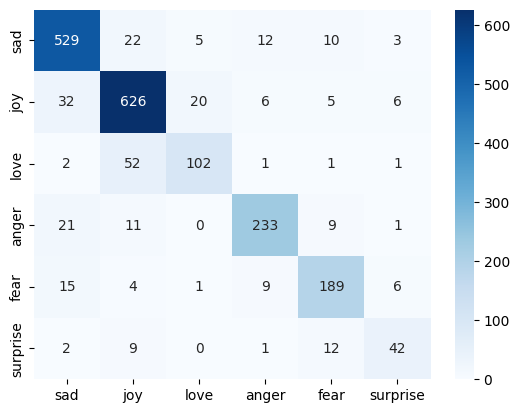

In [12]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=emotion, yticklabels=emotion)

In [13]:
# Optionally, display the results
test_data['predicted_label'] = y_pred
test_data.loc[:,['text', 'label', 'predicted_label']].head(25)

,text,label,predicted_label
0,im feeling rather rotten so im not very ambiti...,0,0
1,im updating my blog because i feel shitty,0,0
2,i never make her separate from me because i do...,0,0
3,i left with my bouquet of red and yellow tulip...,1,1
4,i was feeling a little vain when i did this one,0,0
5,i cant walk into a shop anywhere where i do no...,4,4
6,i felt anger when at the end of a telephone call,3,0
7,i explain why i clung to a relationship with a...,1,1
8,i like to have the same breathless feeling as ...,1,1
9,i jest i feel grumpy tired and pre menstrual w...,3,3


# 5. Live Implementation 

In [14]:
print("Enter a text and label to predict the sentiment")
print("Labels: 0 = sad, 1 = joy, 2 = love, 3 = anger, 4 = fear, 5 = surprise")
input_text = input("Enter a text: ")
input_label = int(input("Enter a label: "))
input_data = pd.DataFrame({'text': [input_text], 'label': [input_label]})

X_input_combined = create_features(input_data)
y_input_pred = clf.predict(X_input_combined)

print(f"Text: {input_text}")
print(f"Label: {input_label}")
print(f"Predicted label: {y_input_pred[0]}")

Enter a text and label to predict the sentiment
Labels: 0 = sad, 1 = joy, 2 = love, 3 = anger, 4 = fear, 5 = surprise
Text: I am a winner 
Label: 1
Predicted label: 1
